## Loading Data & Packages

In [2]:
# K-Means, CURE, DBSCAN

import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn import metrics



from yellowbrick.cluster import KElbowVisualizer
from pyclustering.cluster.cure import cure
from pyclustering.cluster import cluster_visualizer
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall

%matplotlib inline

C:\Users\reddy\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Analysis & Preproccessing

In [3]:
df = pd.read_csv('Data/Online_Retail_Data_Set.csv',
                 encoding="ISO-8859-1",
                 dtype={'CustomerID': str,'InvoiceID': str})

### Exploring Dataset

In [62]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Outliers

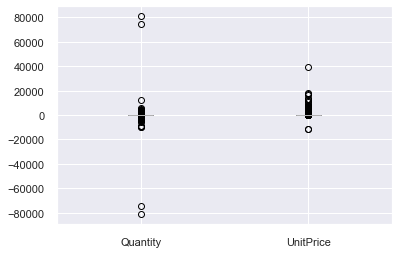

In [63]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot()

### Removing Null Values & filter Data on Quantity to be Positive

In [64]:
df=df.dropna().reset_index()
df = df[df.Quantity <=10000]
df = df[df.Quantity >=0]
df=df.sort_values(['Quantity'],ascending=False)
df.shape

(397921, 9)

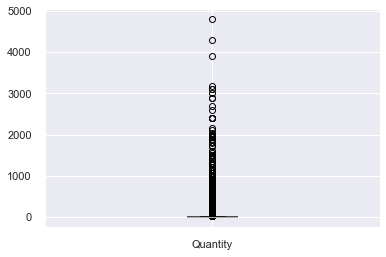

In [65]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot('Quantity')

### Countries Contribution at Dataset 

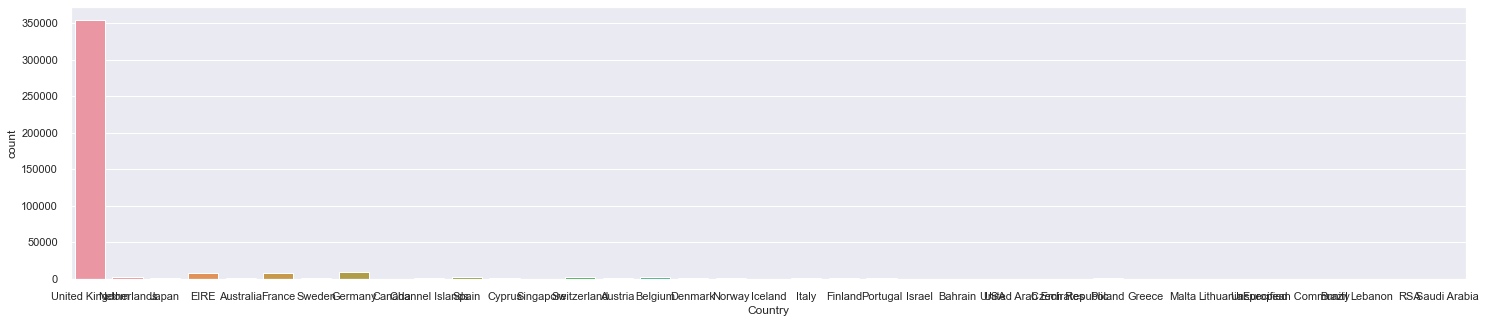

In [66]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Country", data=df)

### Selecting only UK due to sample size

In [67]:
dfuk=df[df['Country']=='United Kingdom']



### Creating the metrics per Customers due to create the customer Segmentation

We are going to run the project based on how much times does the customer bought, average price of the items that he buys and quantity per buy. 

In [68]:
dfukg = (dfuk.groupby(['CustomerID','Country'],as_index=False)
          .agg({'InvoiceNo':'nunique', 'StockCode':'nunique','UnitPrice':'mean','Quantity':'sum'}))
dfukg
dfukg.reset_index()
dfukg['avgitems']=dfukg['Quantity']/dfukg['InvoiceNo']
db=dfukg[['InvoiceNo','UnitPrice','avgitems']]



### Mark and Removing the outliers

In [69]:
import numpy as np

i=0 
while i<=len(db)-1:
    quartile_1, quartile_3 = np.percentile(db['avgitems'], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr *1.5 )
    upper_bound = quartile_3 + (iqr *1.5)
    
    if db.loc[i,'avgitems']> upper_bound:
        db.loc[i,'outlier']=1
    elif db.loc[i,'avgitems']< lower_bound:
        db.loc[i,'outlier']=1
    else:
        db.loc[i,'outlier']=0
    i=i+1
    
db

C:\Users\reddy\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\reddy\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,InvoiceNo,UnitPrice,avgitems,outlier
0,11,4.367864,115.909091,0.0
1,210,2.655701,122.609524,0.0
2,5,4.999950,294.200000,0.0
3,4,1.904746,180.500000,0.0
4,1,2.498333,70.000000,0.0
...,...,...,...,...
3914,1,4.765000,45.000000,0.0
3915,1,5.622857,54.000000,0.0
3916,2,5.199167,51.500000,0.0
3917,16,1.614987,87.312500,0.0


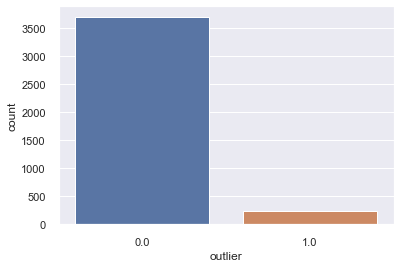

In [70]:
ax = sns.countplot(x="outlier", data=db)

In [71]:
db=db[db['outlier']==0]
db= db.drop(columns=['outlier'])
db

,InvoiceNo,UnitPrice,avgitems
0,11,4.367864,115.909091
1,210,2.655701,122.609524
2,5,4.999950,294.200000
3,4,1.904746,180.500000
4,1,2.498333,70.000000
...,...,...,...
3913,1,3.283333,66.000000
3914,1,4.765000,45.000000
3915,1,5.622857,54.000000
3916,2,5.199167,51.500000


## K-Means with not normalized data

### Elbow Method

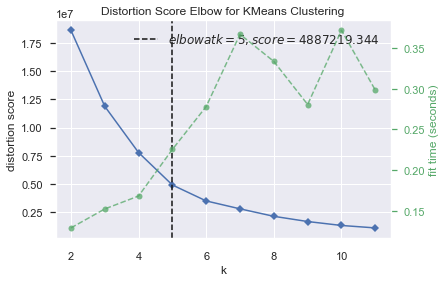

In [72]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(db)  
visualizer.show()        

### Kmeans

[[4.52252252e+00 2.71595376e+00 4.06059461e+02]
 [3.34464555e+00 5.70246393e+00 6.73618725e+01]
 [4.45732689e+00 3.05506243e+00 1.57329386e+02]
 [4.84673367e+00 2.67882897e+00 2.68145083e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]]
[2 2 3 ... 1 1 1]


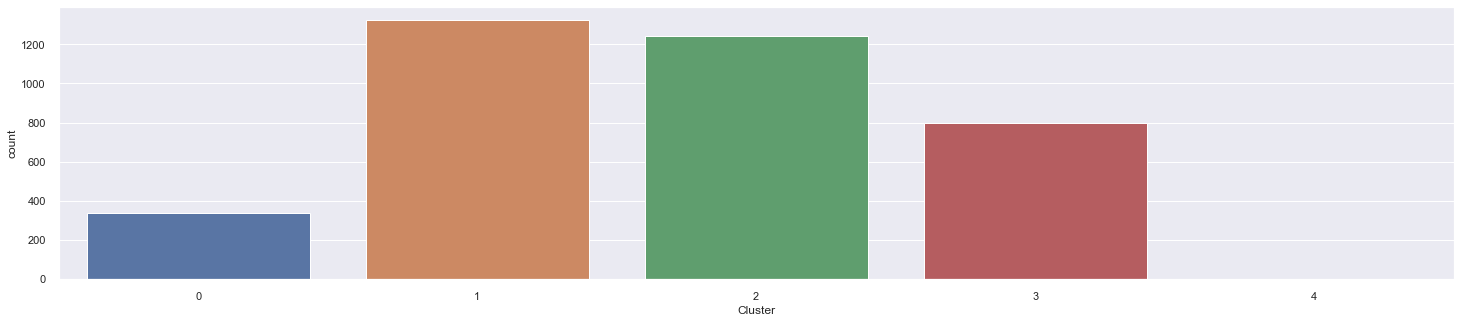

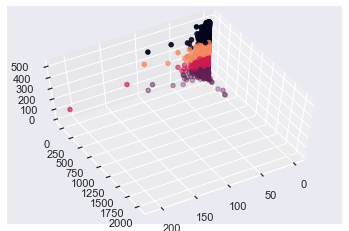

In [73]:
kmeans = KMeans(5)
kmeans.fit(db)
identified_clusters = kmeans.fit_predict(db)
data_with_clusters = db.copy()
data_with_clusters['Cluster'] = identified_clusters
print(kmeans.cluster_centers_)
print(identified_clusters)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=data_with_clusters)
data_with_clusters.groupby(['Cluster']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

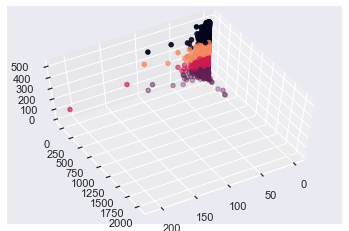

In [74]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

In [75]:
data_with_clusters[data_with_clusters['Cluster']==4]

,InvoiceNo,UnitPrice,avgitems,Cluster
3594,1,2033.1,1.0,4


In [76]:
kmeans.cluster_centers_


array([[4.52252252e+00, 2.71595376e+00, 4.06059461e+02],
       [3.34464555e+00, 5.70246393e+00, 6.73618725e+01],
       [4.45732689e+00, 3.05506243e+00, 1.57329386e+02],
       [4.84673367e+00, 2.67882897e+00, 2.68145083e+02],
       [1.00000000e+00, 2.03310000e+03, 1.00000000e+00]])

## K-Means with  normalized data

### Scale Data

In [77]:
scaler = StandardScaler()
x_scaled=scaler.fit(db)
x_scaled = scaler.fit_transform(db)
x_scaled

array([[ 9.85610419e-01, -2.03503047e-03, -5.05487418e-01],
       [ 2.96065827e+01, -4.91715951e-02, -4.44316536e-01],
       [ 1.22666532e-01,  1.53665481e-02,  1.12220025e+00],
       ...,
       [-4.52629392e-01,  3.25154449e-02, -1.07067980e+00],
       [-3.08805411e-01,  2.08510718e-02, -1.09350328e+00],
       [ 1.70473033e+00, -7.78228751e-02, -7.66556918e-01]])

### Elbow

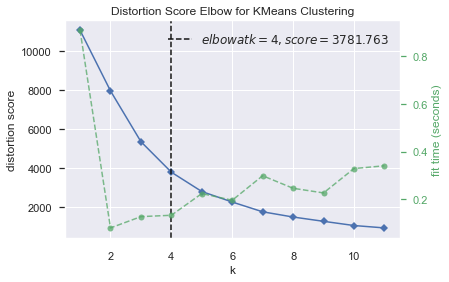

In [78]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show()     

### Kmeans

[2 2 3 ... 1 1 1]
[[4.52252252e+00 2.71595376e+00 4.06059461e+02]
 [3.34464555e+00 5.70246393e+00 6.73618725e+01]
 [4.45732689e+00 3.05506243e+00 1.57329386e+02]
 [4.84673367e+00 2.67882897e+00 2.68145083e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]]


,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
0,2490,2490,2490
1,1,1,1
2,7,7,7
3,1200,1200,1200


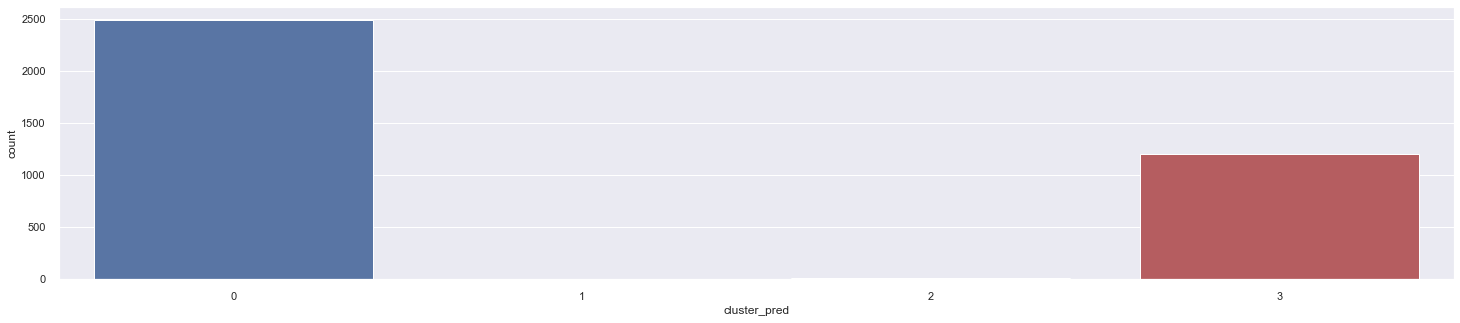

In [79]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
clusters_scaled = db.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(kmeans.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

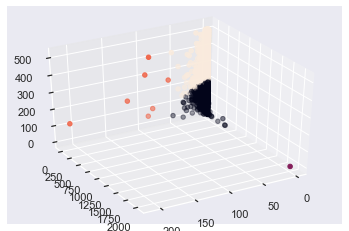

In [80]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

## DBSCAN with Normalized Data

,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
-1,44,44,44
0,3649,3649,3649
1,5,5,5


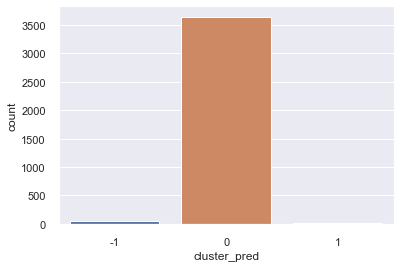

In [82]:

stscaler = StandardScaler().fit(db)
db11 = stscaler.transform(db)
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(db11)
clusters_scaled = db.copy()
clusters_scaled['cluster_pred']=dbsc.fit_predict(db11)
clusters_scaled
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()


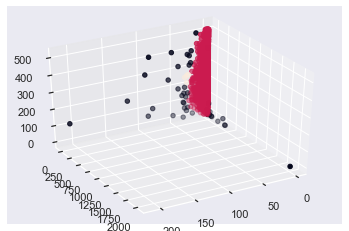

In [84]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

## DBSCAN 

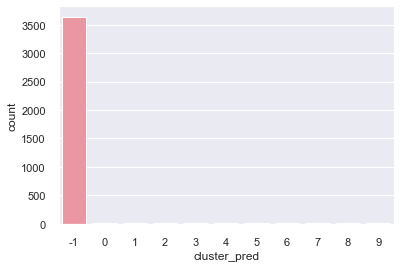

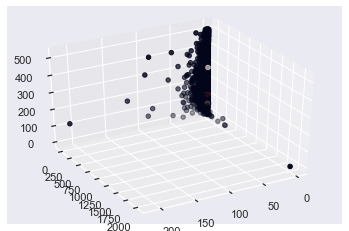

In [85]:
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(db)
data_with_clusters = db.copy()
data_with_clusters['cluster_pred']=dbsc.fit_predict(data_with_clusters)
data_with_clusters
ax = sns.countplot(x="cluster_pred", data=data_with_clusters)
data_with_clusters.groupby(['cluster_pred']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)

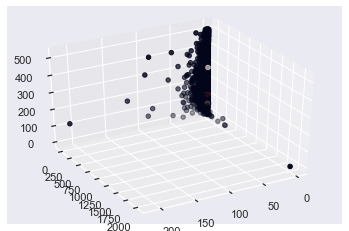

In [86]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)